In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from mixedbridge.stochastic_processes.examples import BrownianProcess, BrownianAuxProcess, BrownianBridgeProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess, MixedGuidedBridgeProcess
from mixedbridge.solvers.sde import WienerProcess, Euler, ModifiedEuler

## Loss check

In [80]:
dim = 1
T = 1.0
dt = 1. / 500
dtype = jnp.float32

gamma = 2.0
sigma = 1.0

rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.0], dtype=dtype)
v  = jnp.array([0.0], dtype=dtype)
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc        = WienerProcess(T=T, dt=dt, dim=dim, t_scheme=t_scheme, dtype=dtype)
ori_proc           = BrownianProcess(gamma=gamma, sigma=sigma, T=T, dim=dim, dtype=dtype)
aux_proc           = BrownianAuxProcess(gamma=0.0, sigma=sigma, T=T, dim=dim, dtype=dtype)

guided_bridge_proc = GuidedBridgeProcess(ori_proc=ori_proc, 
                                         aux_proc=aux_proc, 
                                         x0=x0,
                                         v=v,
                                         L0=jnp.eye(dim, dtype=dtype), 
                                         Sigma0=jnp.eye(dim, dtype=dtype)*1e-10,
                                         ts=wiener_proc.ts,
                                         ode_solver_kernel=ode_solver_kernel)

In [81]:
# guided_bridge_solver = Euler(sde=guided_bridge_proc, wiener=wiener_proc)
guided_bridge_solver = ModifiedEuler(sde=guided_bridge_proc, wiener=wiener_proc)

batch_size = 256
wiener_paths = wiener_proc.sample_path(rng_key=rng_key, 
                                       batch_size=batch_size)
guided_bridge_paths = guided_bridge_solver.solve(x0=x0, 
                                                 dWs=wiener_paths.dxs, 
                                                 batch_size=batch_size)
print(guided_bridge_paths)

 sample path contains 256 samples，each sample runs 501 steps:
 xs.shape: (256, 501, 1)
 ts.shape: (501,)
 dWs.shape: (256, 500, 1)
 dts.shape: (500,)
 log_likelihood.shape: (256,)
 dlog_ll.shape: (256, 500)


In [82]:
psi = jnp.exp(guided_bridge_paths.log_likelihood)
print(psi.max())
print(psi.argmax())
print(psi.min())

82.82555
43
4.868598e-05


In [83]:
def plot_paths_and_losses(batch_size, ax1, ax2, ax3):
    wiener_paths = wiener_proc.sample_path(rng_key=rng_key, 
                                           batch_size=batch_size)
    guided_bridge_paths = guided_bridge_solver.solve(x0=x0, 
                                                    dWs=wiener_paths.dxs, 
                                                    batch_size=batch_size)
    print(guided_bridge_paths)
    
    for i in range(batch_size):
        ax1.plot(guided_bridge_paths.ts, guided_bridge_paths.xs[i], color='blue', alpha=0.5, zorder=1)
        ax1.plot(wiener_paths.ts, wiener_paths.xs[i], color='grey', alpha=0.4, zorder=0)
        
    ax1.plot([], [], color='blue', label=r'$X^{\circ}_t=\mathcal{GP}(W_t)$', alpha=0.5)
    ax1.plot([], [], color='grey', label=r'$W_t$', alpha=0.4)
    ax1.grid(True)
    ax1.set_xlabel("t")
    ax1.set_ylabel("x")
    ax1.set_title(r'$X^{\circ}_t$ and $W_t$')
    ax1.legend()
    
    dWs = wiener_paths.dxs
    log_lls = guided_bridge_paths.log_likelihood

    def rn_derivative(theta: jnp.ndarray, dWs: jnp.ndarray, T: float):
        sto_integrand_fn = lambda dW: jnp.inner(theta, dW)
        sto_int = jnp.sum(jax.vmap(sto_integrand_fn, in_axes=1, out_axes=1)(dWs), axis=1)
        det_int = 0.5 * jnp.inner(theta, theta) * T
        return sto_int - det_int

    thetas = jnp.linspace(-2.0 * jnp.abs(-gamma/sigma), 2.0 * jnp.abs(-gamma/sigma), 500).reshape(-1, 1)
    rn_ders = jax.vmap(rn_derivative, in_axes=(0, None, None))(thetas, dWs, T)
    losses = jnp.exp(log_lls) * rn_ders
    loss = jnp.mean(losses, axis=-1)

    max_loss_idx = jnp.argmax(loss)
    max_loss_theta = thetas[max_loss_idx][0]
    max_loss_value = loss[max_loss_idx]

    expected_theta = -gamma / sigma
    expected_loss_idx = jnp.argmin(jnp.abs(thetas.squeeze() - expected_theta))
    expected_loss_value = loss[expected_loss_idx]
    
    ax2.scatter(
        jnp.exp(log_lls), 
        rn_ders[expected_loss_idx], 
        color='green', 
        s=5,
    )
    max_ll_idx = jnp.argmax(jnp.exp(log_lls))
    ax2.scatter(
        jnp.exp(log_lls[max_ll_idx]),
        rn_ders[expected_loss_idx, max_ll_idx],
        color='orange',
        s=5,
        zorder=5,
    )
        
    ax1.plot(guided_bridge_paths.ts, guided_bridge_paths.xs[max_ll_idx], color='orange', alpha=0.5, zorder=1)
    ax1.plot(wiener_paths.ts, wiener_paths.xs[max_ll_idx], color='red', alpha=0.4, zorder=0)
    
    ax2.set_xlabel(r'$\Psi(X^{\circ}_T)$')
    ax2.set_ylabel(r'$\int^T_0 \theta dW_t - \frac{1}{2}\int^T_0 \|\theta\|^2 dt$')
    ax2.set_title(r'$\Psi(X^{\circ}_T)$ vs $\int^T_0 \theta dW_t - \frac{1}{2}\int^T_0 \|\theta\|^2 dt$')
    ax2.grid(True)

    ax3.plot(thetas.squeeze(), loss)

    ax3.scatter(max_loss_theta, max_loss_value, color='red', s=100, zorder=5, label=fr'Max Loss: ($\theta$={max_loss_theta:.4e}, Loss={max_loss_value:.4e})')
    ax3.scatter(expected_theta, expected_loss_value, color='green', s=100, zorder=5, label=fr'Optimal $\theta^{{\star}}=-\gamma/\sigma$: ($\theta$={expected_theta:.4e}, Loss={expected_loss_value:.4e})')

        
    ax3.set_xlabel(r'$\theta$')
    ax3.set_ylabel('Loss')
    # ax3.set_yscale('symlog')
    ax3.set_title(fr'Loss vs $\theta$, #samples={batch_size}')
    ax3.legend()
    ax3.grid(True) 

 sample path contains 16 samples，each sample runs 501 steps:
 xs.shape: (16, 501, 1)
 ts.shape: (501,)
 dWs.shape: (16, 500, 1)
 dts.shape: (500,)
 log_likelihood.shape: (16,)
 dlog_ll.shape: (16, 500)
 sample path contains 64 samples，each sample runs 501 steps:
 xs.shape: (64, 501, 1)
 ts.shape: (501,)
 dWs.shape: (64, 500, 1)
 dts.shape: (500,)
 log_likelihood.shape: (64,)
 dlog_ll.shape: (64, 500)
 sample path contains 256 samples，each sample runs 501 steps:
 xs.shape: (256, 501, 1)
 ts.shape: (501,)
 dWs.shape: (256, 500, 1)
 dts.shape: (500,)
 log_likelihood.shape: (256,)
 dlog_ll.shape: (256, 500)
 sample path contains 512 samples，each sample runs 501 steps:
 xs.shape: (512, 501, 1)
 ts.shape: (501,)
 dWs.shape: (512, 500, 1)
 dts.shape: (500,)
 log_likelihood.shape: (512,)
 dlog_ll.shape: (512, 500)


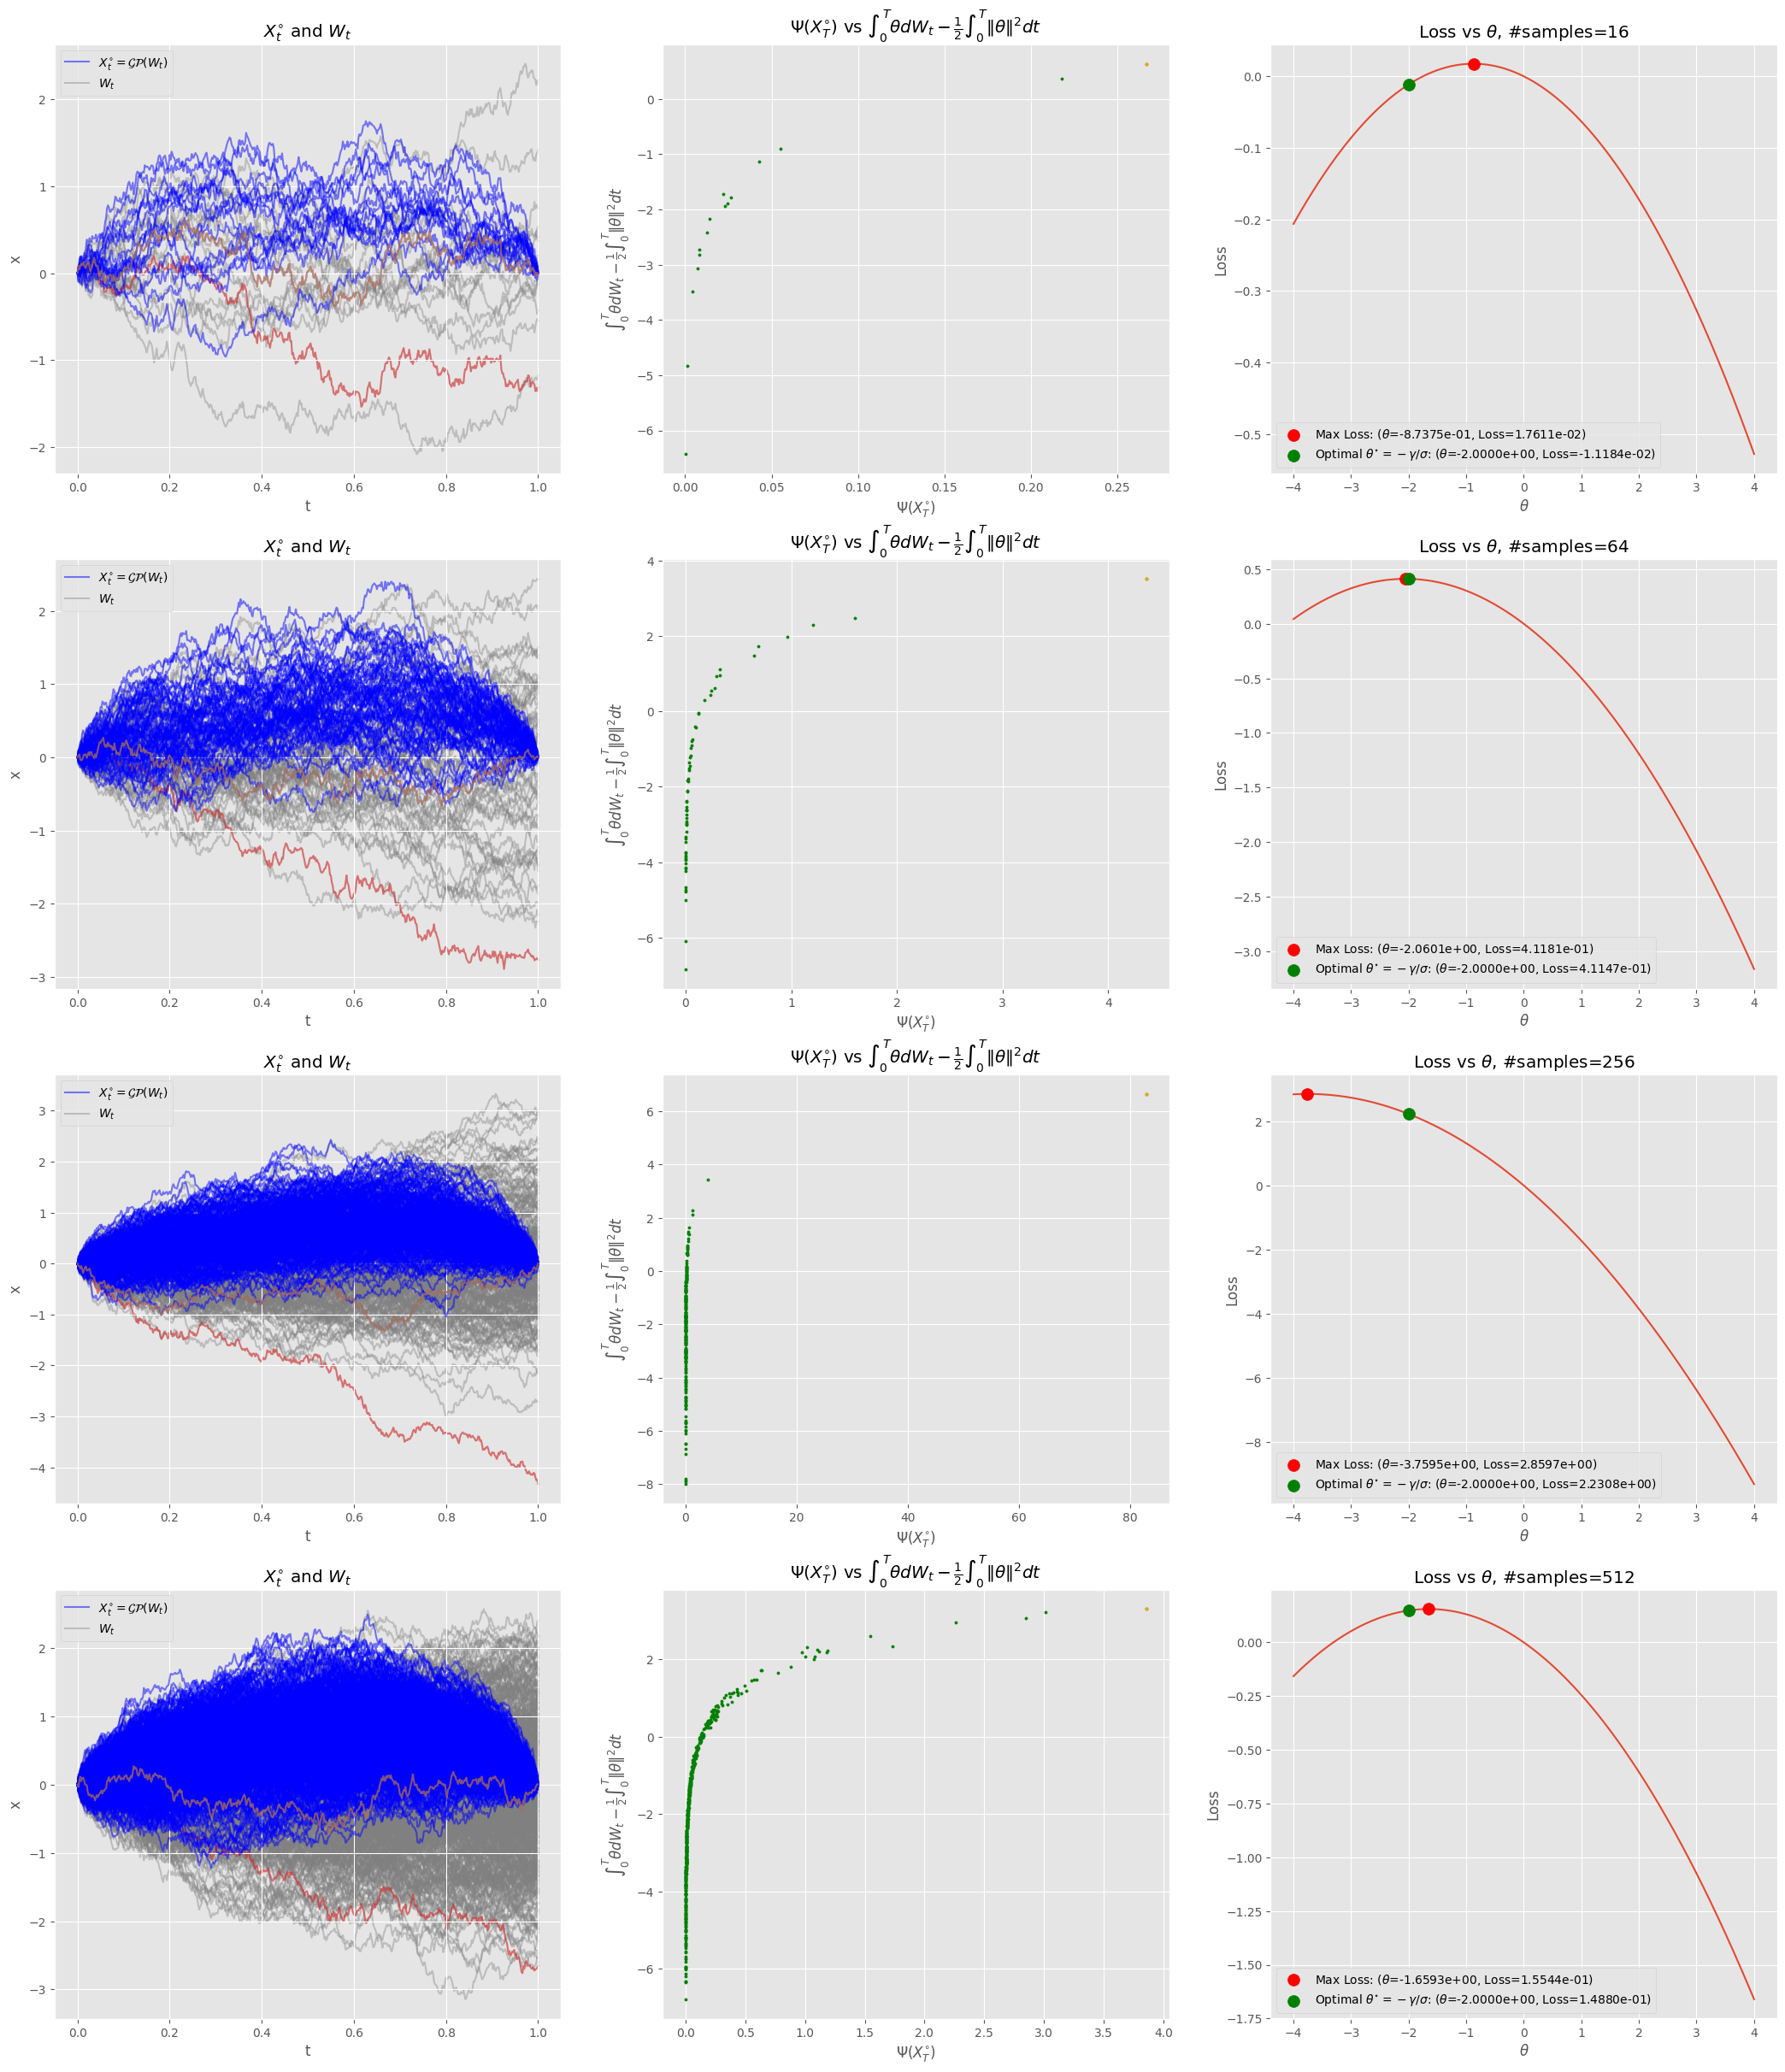

In [84]:
fig, axes = plt.subplots(4, 3, figsize=(26, 30))
batch_sizes = [16, 64, 256, 512]
for i, batch_size in enumerate(batch_sizes):
    plot_paths_and_losses(batch_size, axes[i, 0], axes[i, 1], axes[i, 2])
plt.show()
# fig.savefig(f"gamma={gamma:.1f}.pdf", dpi=150)

In [29]:
batch_size = 256
wiener_path = wiener_proc.sample_path(rng_key=rng_key,
                                      batch_size=batch_size)
guided_bridge_path = guided_bridge_solver.solve(x0=x0,
                                                dWs=wiener_path.dxs,
                                                batch_size=batch_size)
print(guided_bridge_path)

 sample path contains 256 samples，each sample runs 501 steps:
 xs.shape: (256, 501, 1)
 ts.shape: (501,)
 dWs.shape: (256, 500, 1)
 dts.shape: (500,)
 log_likelihood.shape: (256,)
 dlog_ll.shape: (256, 500)


In [30]:
psi = jnp.exp(guided_bridge_path.log_likelihood)
anomaly_indice = jnp.where(psi > 10)[0]

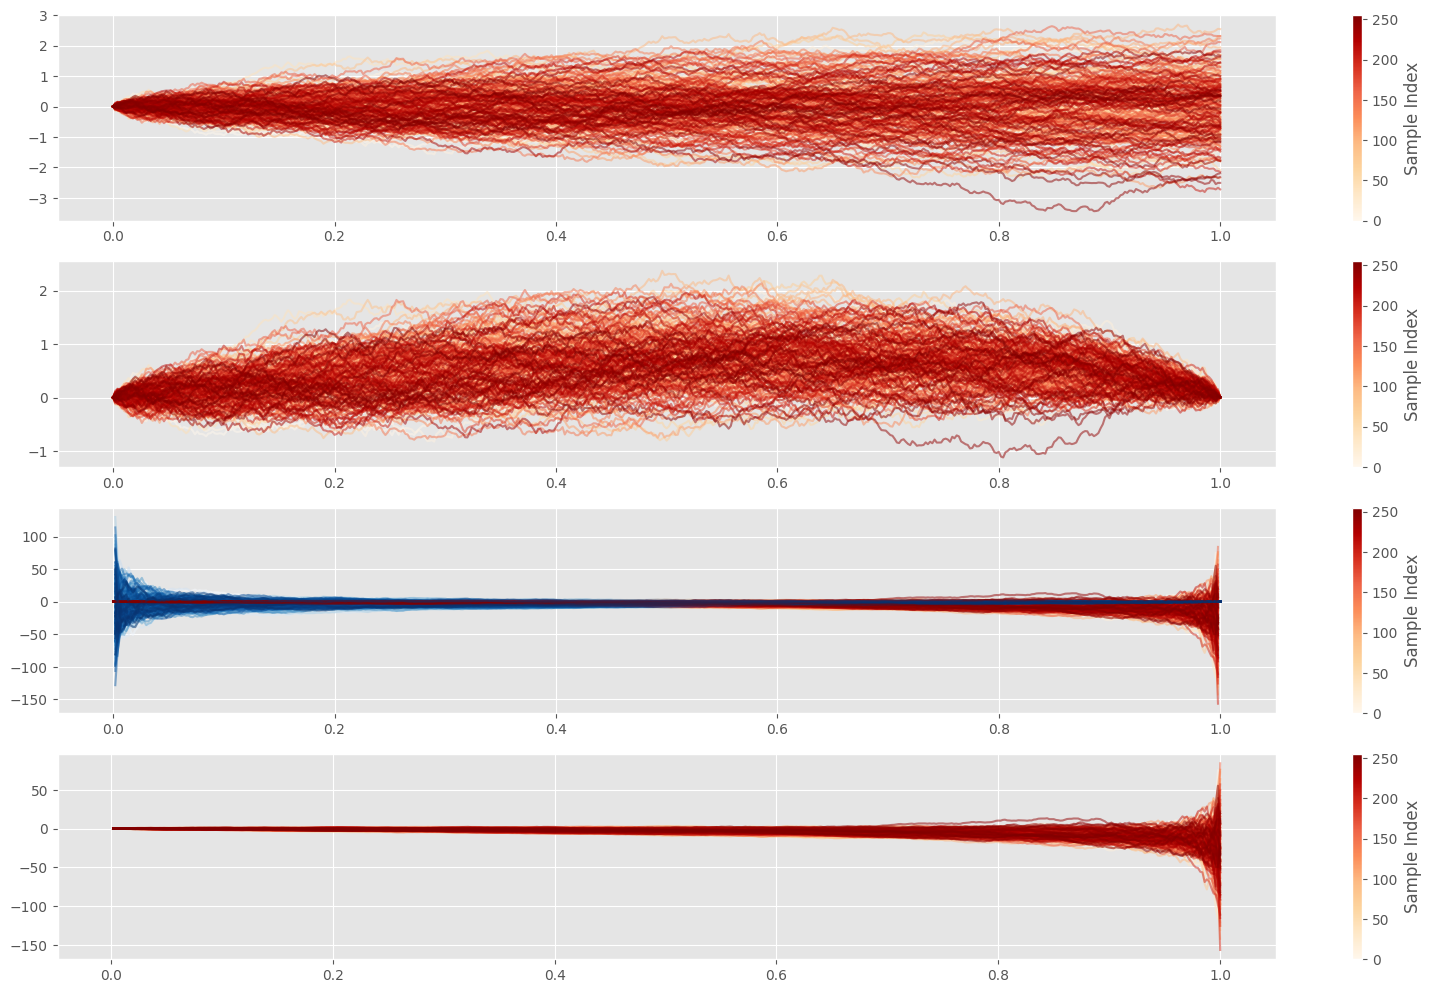

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10))
G_integrand = -gamma * (guided_bridge_path.xs - v) / (T - guided_bridge_path.ts)[None, :, None]

G_integrand_reversed = -gamma * (guided_bridge_path.xs - x0) / (guided_bridge_path.ts)[None, :, None]

# Create a colormap
cmap1 = plt.get_cmap('OrRd')
cmap2 = plt.get_cmap('Blues')
colors1 = cmap1(jnp.linspace(0, 1, batch_size))
colors2 = cmap2(jnp.linspace(0, 1, batch_size))

for i in range(batch_size):
    if i in anomaly_indice:
        continue
    ax1.plot(wiener_path.ts, wiener_path.xs[i], alpha=0.5, color=colors1[i])
    ax2.plot(guided_bridge_path.ts, guided_bridge_path.xs[i], alpha=0.5, color=colors1[i])
    ax3.plot(guided_bridge_path.ts, G_integrand[i], alpha=0.5, color=colors1[i])
    ax3.plot(guided_bridge_path.ts, G_integrand_reversed[i], alpha=0.5, color=colors2[i])
    ax4.plot(guided_bridge_path.ts[1:], guided_bridge_path.dlog_ll[i], alpha=0.5, color=colors1[i])
    
# Add colorbars to show the sample index
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=0, vmax=batch_size-1))
sm.set_array([])

for ax in [ax1, ax2, ax3, ax4]:
    plt.colorbar(sm, ax=ax, label='Sample Index')

plt.tight_layout()
plt.show()

In [32]:
import scipy.stats as stats

In [33]:
def rn_derivative(theta: jnp.ndarray, dWs: jnp.ndarray, T: float):
    sto_integrand_fn = lambda dW: jnp.inner(theta, dW)
    sto_int = jnp.sum(jax.vmap(sto_integrand_fn, in_axes=1, out_axes=1)(dWs), axis=1)
    det_int = 0.5 * jnp.inner(theta, theta) * T
    return sto_int - det_int

theta = - 2.0
batch_size = 1024
wiener_path = wiener_proc.sample_path(rng_key=rng_key, 
                                      batch_size=batch_size)
rn_der = rn_derivative(theta, wiener_path.dxs, T)
print(rn_der.shape)


(1024, 1)


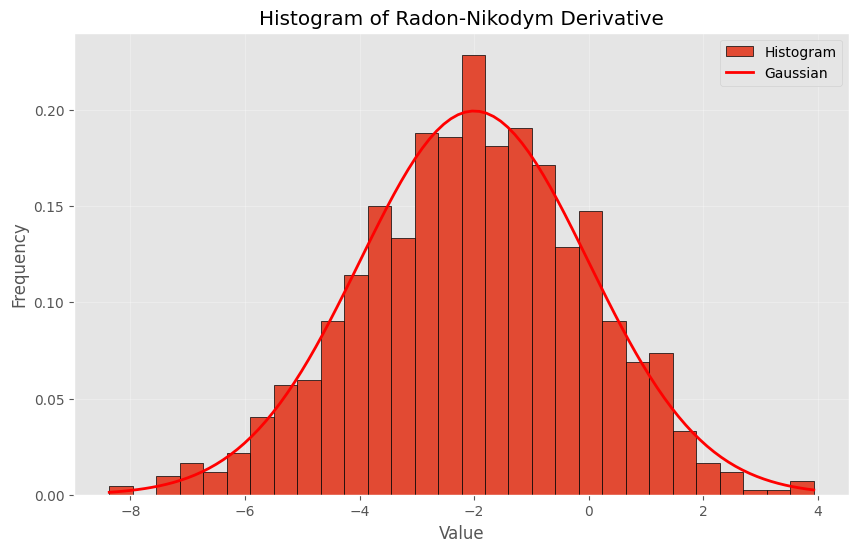

In [34]:
# Create a histogram of rn_der
plt.figure(figsize=(10, 6))
plt.hist(rn_der, bins=30, edgecolor='black', density=True, label='Histogram')
plt.title('Histogram of Radon-Nikodym Derivative')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Calculate mean and standard deviation for the Gaussian
mean = -gamma**2 * T / 2
std_dev = abs(theta)

# Generate x values for the Gaussian curve
x = jnp.linspace(min(rn_der), max(rn_der), 100)

# Calculate the Gaussian values
gaussian = stats.norm.pdf(x, mean, std_dev)

# Plot the Gaussian curve
plt.plot(x, gaussian, 'r-', lw=2, label='Gaussian')

plt.legend()
plt.show()


## A Brownian Sanity check
We use a Brownian bridge with constant drift as the target bridge, and approximate it by learning from another Brownian bridge without drift, specifically:
$$
\mathrm{d}X_t = \gamma\mathrm{d}t + \sigma\mathrm{d}W_t \\
\mathrm{d}X^{\star}_t = \left\{\gamma + \frac{v - X^{\star}_t - \gamma * (T - t)}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t = \left\{\frac{v - X^{\star}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
And the auxiliary and guided processes are:
$$
\mathrm{d}\tilde{X}_t = \sigma\mathrm{d}W_t \\
\mathrm{d}X^{\circ}_t = \left\{\gamma + \frac{v - X^{\circ}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Therefore, if the neural guided process is constructed as:
$$
\mathrm{d}X^{\diamond}_t = \left\{\gamma + \frac{v - X^{\circ}_t}{T-t} + \sigma\nu_{\theta}(t, x)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
We can expect:
$$
\nu_{\theta^*}(t, x) = -\frac{\gamma}{\sigma}
$$

In [35]:
dim = 1
T = 1.0
dt = 1. / 500
dtype = jnp.float32

gamma = 2.0
sigma = 1.0

rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.0], dtype=dtype)
v  = jnp.array([0.0], dtype=dtype)

In [36]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc        = WienerProcess(T=T, dt=dt, dim=dim, t_scheme=t_scheme, dtype=dtype)
ori_proc           = BrownianProcess(gamma=gamma, sigma=sigma, T=T, dim=dim, dtype=dtype)
aux_proc           = BrownianAuxProcess(gamma=0.0, sigma=sigma, T=T, dim=dim, dtype=dtype)
true_bridge_proc   = BrownianBridgeProcess(gamma=gamma, sigma=sigma, score_fn=None, v=v, dtype=dtype, T=T)

guided_bridge_proc = GuidedBridgeProcess(ori_proc=ori_proc, 
                                         aux_proc=aux_proc, 
                                         x0=x0,
                                         v=v,
                                         L0=jnp.eye(dim, dtype=dtype), 
                                         Sigma0=jnp.eye(dim, dtype=dtype)*1e-10,
                                         ts=wiener_proc.ts,
                                         ode_solver_kernel=ode_solver_kernel)

true_bridge_solver   = ModifiedEuler(sde=true_bridge_proc, wiener=wiener_proc)
guided_bridge_solver = ModifiedEuler(sde=guided_bridge_proc, wiener=wiener_proc)

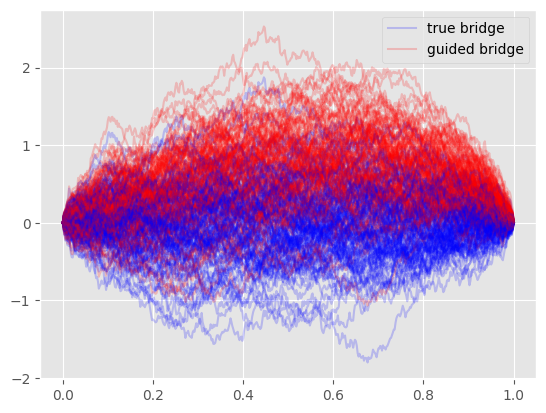

In [37]:
batch_size = 128
# dWs = jnp.zeros((n_samples, int(T/dt), dim))
dWs = None
true_bridge_paths   = true_bridge_solver.solve(x0=x0, rng_key=rng_key, dWs=dWs, batch_size=batch_size)
guided_bridge_paths = guided_bridge_solver.solve(x0=x0, rng_key=rng_key, dWs=dWs, batch_size=batch_size)

plt.figure()
for i in range(batch_size):
    plt.plot(true_bridge_paths.ts, true_bridge_paths.xs[i], color='blue', alpha=0.2)
    plt.plot(guided_bridge_paths.ts, guided_bridge_paths.xs[i], color='red', alpha=0.2)

plt.plot([], [], color='blue', label='true bridge', alpha=0.2)
plt.plot([], [], color='red', label='guided bridge', alpha=0.2)
plt.legend()
plt.show()

### Check the backward ODE solving
First, since we know the true 
$$\tilde{r}(t, x) = \nabla \log \tilde{p}(t, x; T, v) = \frac{v-x}{T-t},$$ 
we can compare it against the numerical solution of backward ODE.

Second, $G(t, x)$ is computed by:
$$
G(t, x) = \langle (b(t, x) - \tilde{b}(t, x)), \tilde{r}(t, x) \rangle - \frac{1}{2}\mathrm{Tr}\left\{ [a(t, x) - \tilde{a}(t)][H(s) - \tilde{r}(t, x)\tilde{r}^T(t, x)]\right\}
$$
Given the case we study, $a(t, x) = \tilde{a}(t)$, therefore,
$$
G(t, x) = \langle (b(t, x) - \tilde{b}(t, x)), \tilde{r}(t, x) \rangle = \frac{\gamma(v-x)}{T-t}
$$

(500,) (16, 500, 1)


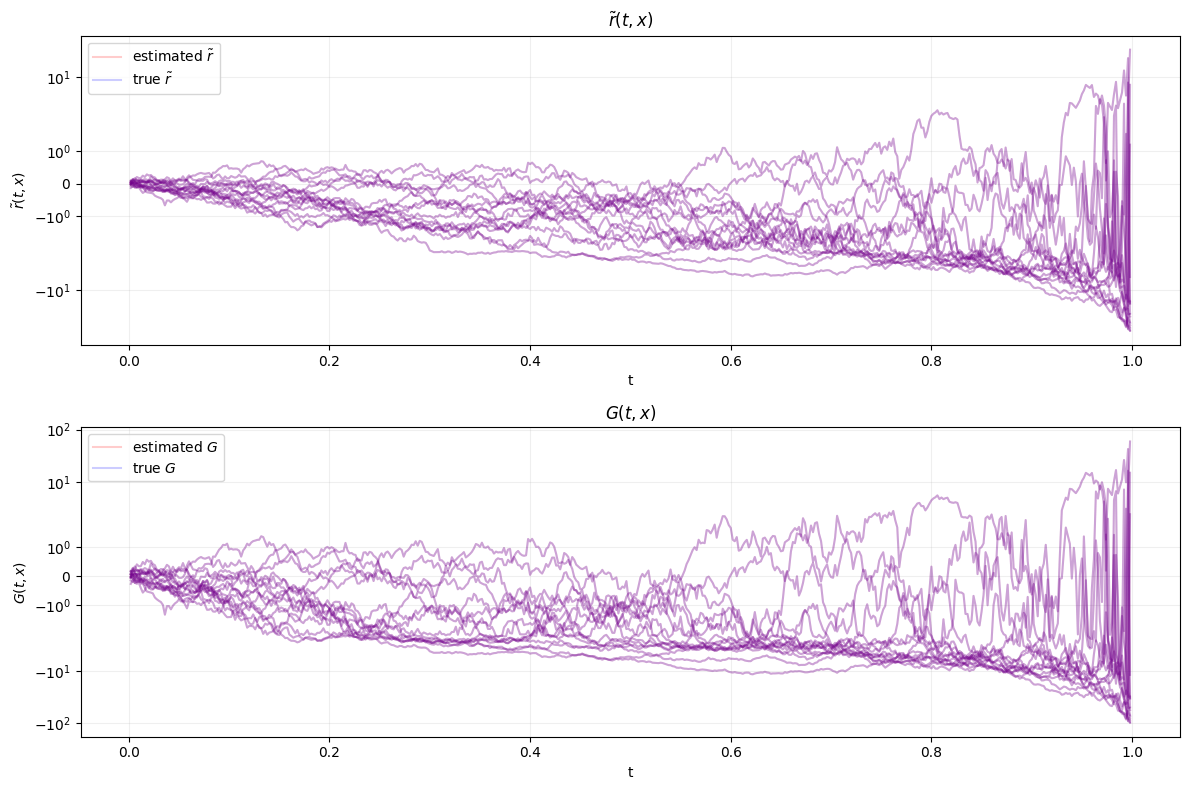

In [65]:
ts, xs = guided_bridge_paths.ts, guided_bridge_paths.xs
print(ts.shape, xs.shape)
est_rs = jax.vmap(
    jax.vmap(
        lambda t, x: guided_bridge_proc.r(t, x)
    ), 
    in_axes=(None, 0)
)(ts[:-1], xs[:, :-1])
true_rs = jax.vmap(
    jax.vmap(
        lambda t, x: (v - x) / (T - t + 1e-10)
    ), 
    in_axes=(None, 0)
)(ts[:-1], xs[:, :-1])

est_Gs = jax.vmap(
    jax.vmap(
        lambda t, x: guided_bridge_proc.G(t, x)
    ), 
    in_axes=(None, 0)
)(ts[:-1], xs[:, :-1])
true_Gs = jax.vmap(
    jax.vmap(
        lambda t, x: gamma * (v - x) / (T - t + 1e-10)
    ), 
    in_axes=(None, 0)
)(ts[:-1], xs[:, :-1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# First subplot
for i in range(n_samples):
    ax1.plot(ts[:-1], est_rs[i], color='red', alpha=0.2)
    ax1.plot(ts[:-1], true_rs[i], color='blue', alpha=0.2)
    
ax1.plot([], [], color='red', alpha=0.2, label=r'estimated $\tilde{r}$')
ax1.plot([], [], color='blue', alpha=0.2, label=r'true $\tilde{r}$')
ax1.legend()

ax1.set_yscale('symlog')
ax1.set_ylabel(r"$\tilde{r}(t, x)$")
ax1.set_xlabel("t")
ax1.set_title(r"$\tilde{r}(t, x)$")
ax1.grid(True, which="both", ls="-", alpha=0.2)

# Second subplot
for i in range(n_samples):
    ax2.plot(ts[:-1], est_Gs[i], color='red', alpha=0.2)
    ax2.plot(ts[:-1], true_Gs[i], color='blue', alpha=0.2)
    
ax2.set_yscale('symlog')
ax2.plot([], [], color='red', alpha=0.2, label=r'estimated $G$')
ax2.plot([], [], color='blue', alpha=0.2, label=r'true $G$')
ax2.legend()
ax2.set_ylabel(r'$G(t, x)$')
ax2.set_xlabel('t')
ax2.set_title(r'$G(t, x)$')
ax2.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

## NN training

In [38]:
import flax.linen as nn
from flax import struct
from flax.training import train_state
import optax

In [39]:
# a very simple MLP
class MLP(nn.Module):
    
    @nn.compact
    def __call__(self, t, x, training=False):
        t = jnp.expand_dims(t, axis=-1)
        x = jnp.concatenate([t, x], axis=-1)
        x = nn.Dense(20, use_bias=True)(x)
        # x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Dense(20, use_bias=True)(x)
        # x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Dense(20, use_bias=True)(x)
        # x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Dense(dim, use_bias=True)(x)
        return x


In [62]:
@struct.dataclass
class TrainState(train_state.TrainState):
    batch_stats: dict = struct.field(pytree_node=True)

    @classmethod
    def create(cls, *, apply_fn, params, tx, batch_stats, **kwargs):
        """Creates a new instance with `step=0` and initialized `opt_state`."""
        opt_state = tx.init(params)
        return cls(
            step=0,
            apply_fn=apply_fn,
            params=params,
            tx=tx,
            opt_state=opt_state,
            batch_stats=batch_stats,
            **kwargs,
        )

def train_model(rng_key, model, path_solver, n_epochs, n_iters, batch_size):
    rng_key, init_key = jax.random.split(rng_key)
    
    dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 1))
    variables = model.init(init_key, dummy_t, dummy_x, training=True)
    params = variables['params']
    batch_stats = variables['batch_stats'] if 'batch_stats' in variables else {}
    
    optimizer = optax.chain(
        optax.adam(1e-3),
        optax.ema(0.995)
    )
    
    model_state = TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
        batch_stats=batch_stats
    )

    def sample_path(rng_key, path_solver):
        path = path_solver.solve(x0=x0, dWs=None, rng_key=rng_key, batch_size=batch_size)
        ts, xs, dWs, dlog_ll = path.ts, path.xs, path.dWs, path.dlog_ll
        ts = jnp.tile(jnp.expand_dims(ts, axis=0), reps=(batch_size, 1))
        return ts, xs, dWs, dlog_ll

    def compute_loss(params, batch_stats, ts, xs, dWs, dlog_ll, state):
        variables = {'params': params, 'batch_stats': batch_stats}
        nus, updated_batch_stats = state.apply_fn(
            variables, 
            ts[:, 1:], 
            xs[:, 1:], 
            training=True,
            mutable=['batch_stats']
        )
        sto_int = jnp.einsum("...i, ...i -> ...", nus, dWs)
        sto_int = jnp.sum(sto_int, axis=1)
        ll = jnp.exp(jnp.sum(dlog_ll, axis=1)*dt)
        det_int = 0.5 * jnp.sum(jnp.sum(jnp.square(nus), axis=-1), axis=1) * dt
        loss = ll * (-sto_int + det_int)
        return jnp.mean(loss), {"ll": ll, "sto_int": sto_int, "det_int": det_int, "batch_stats": updated_batch_stats['batch_stats']}
    
    @jax.jit
    def train_step(state, ts, xs, dWs, log_ll):
        def loss_fn(params):
            loss, aux = compute_loss(params, state.batch_stats, ts, xs, dWs, log_ll, state)
            return loss, aux
        
        (loss, aux), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
        state = state.apply_gradients(grads=grads)
        # Update batch_stats
        state = state.replace(batch_stats=aux['batch_stats'])
        return state, loss, grads, aux
    
    losses = []
    lls = []
    sto_ints = []
    det_ints = []
    gradient_norms = []
    
    for epoch in range(1, n_epochs + 1):
        start_time = time.time()
        epoch_losses = []
        epoch_grad_norms = []
        for iter in range(n_iters):
            rng_key, _ = jax.random.split(rng_key)
            ts, xs, dWs, log_ll = sample_path(rng_key, path_solver)
            model_state, loss, grads, aux = train_step(model_state, ts, xs, dWs, log_ll)
            
            sto_ints.append(aux["sto_int"])
            det_ints.append(aux["det_int"])
            lls.append(aux["ll"])
            
            if jnp.isnan(loss):
                raise ValueError(f"NaN loss detected. Last valid loss: {losses[-1] if losses else None}")
            
            losses.append(loss)
            epoch_losses.append(loss)
            
            # Compute gradient norm
            grad_norm = jnp.sqrt(sum([jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)]))
            
            if jnp.isnan(grad_norm):
                raise ValueError(f"NaN gradient norm detected. Current loss: {losses[-1] if losses else None}, Last valid gradient norm: {gradient_norms[-1] if gradient_norms else None}")
            
            gradient_norms.append(grad_norm)
            epoch_grad_norms.append(grad_norm)
        
        avg_loss = jnp.mean(jnp.array(epoch_losses))
        avg_grad_norm = jnp.mean(jnp.array(epoch_grad_norms))
        print(f"Epoch {epoch:<3} / {n_epochs}, avg loss: {avg_loss:.5f}, avg grad norm: {avg_grad_norm:.5f}, time: {time.time() - start_time:.2f}s")

    return model_state, losses, gradient_norms, lls, sto_ints, det_ints

In [63]:
model = MLP()
n_epochs = 20
n_iters = 200
batch_size = 128

In [64]:
model_state, losses, gradient_norms, lls, sto_ints, det_ints = train_model(rng_key, model, guided_bridge_solver, n_epochs, n_iters, batch_size) 

Epoch 1   / 20, avg loss: -0.16754, avg grad norm: 0.42588, time: 22.41s
Epoch 2   / 20, avg loss: -0.47385, avg grad norm: 1.00685, time: 19.55s
Epoch 3   / 20, avg loss: -0.66352, avg grad norm: 0.81224, time: 22.22s
Epoch 4   / 20, avg loss: -0.64997, avg grad norm: 0.46401, time: 19.54s
Epoch 5   / 20, avg loss: -0.78370, avg grad norm: 0.81361, time: 22.13s
Epoch 6   / 20, avg loss: -0.72537, avg grad norm: 0.54189, time: 19.46s
Epoch 7   / 20, avg loss: -0.69055, avg grad norm: 0.49348, time: 22.22s
Epoch 8   / 20, avg loss: -0.65256, avg grad norm: 0.46776, time: 19.55s
Epoch 9   / 20, avg loss: -0.72011, avg grad norm: 0.47767, time: 22.23s
Epoch 10  / 20, avg loss: -0.77431, avg grad norm: 0.46190, time: 19.57s
Epoch 11  / 20, avg loss: -0.78624, avg grad norm: 0.53133, time: 22.26s
Epoch 12  / 20, avg loss: -1.02103, avg grad norm: 0.84701, time: 19.77s
Epoch 13  / 20, avg loss: -0.89776, avg grad norm: 0.68999, time: 22.45s
Epoch 14  / 20, avg loss: -0.76536, avg grad norm: 

In [65]:
lls = jnp.array(lls)    
sto_ints = jnp.array(sto_ints)
det_ints = jnp.array(det_ints)
print(lls.shape, sto_ints.shape, det_ints.shape)

(4000, 128) (4000, 128) (4000, 128)


In [66]:
print(sto_ints.max(), sto_ints.min(), sto_ints.std())
print(det_ints.max(), det_ints.min(), det_ints.std())
print(lls.max(), lls.min(), lls.std())


49.498837 -0.87268615 3.1143641
59.527363 0.000119666474 2.7091272
400.0918 2.4884998e-06 1.0607008


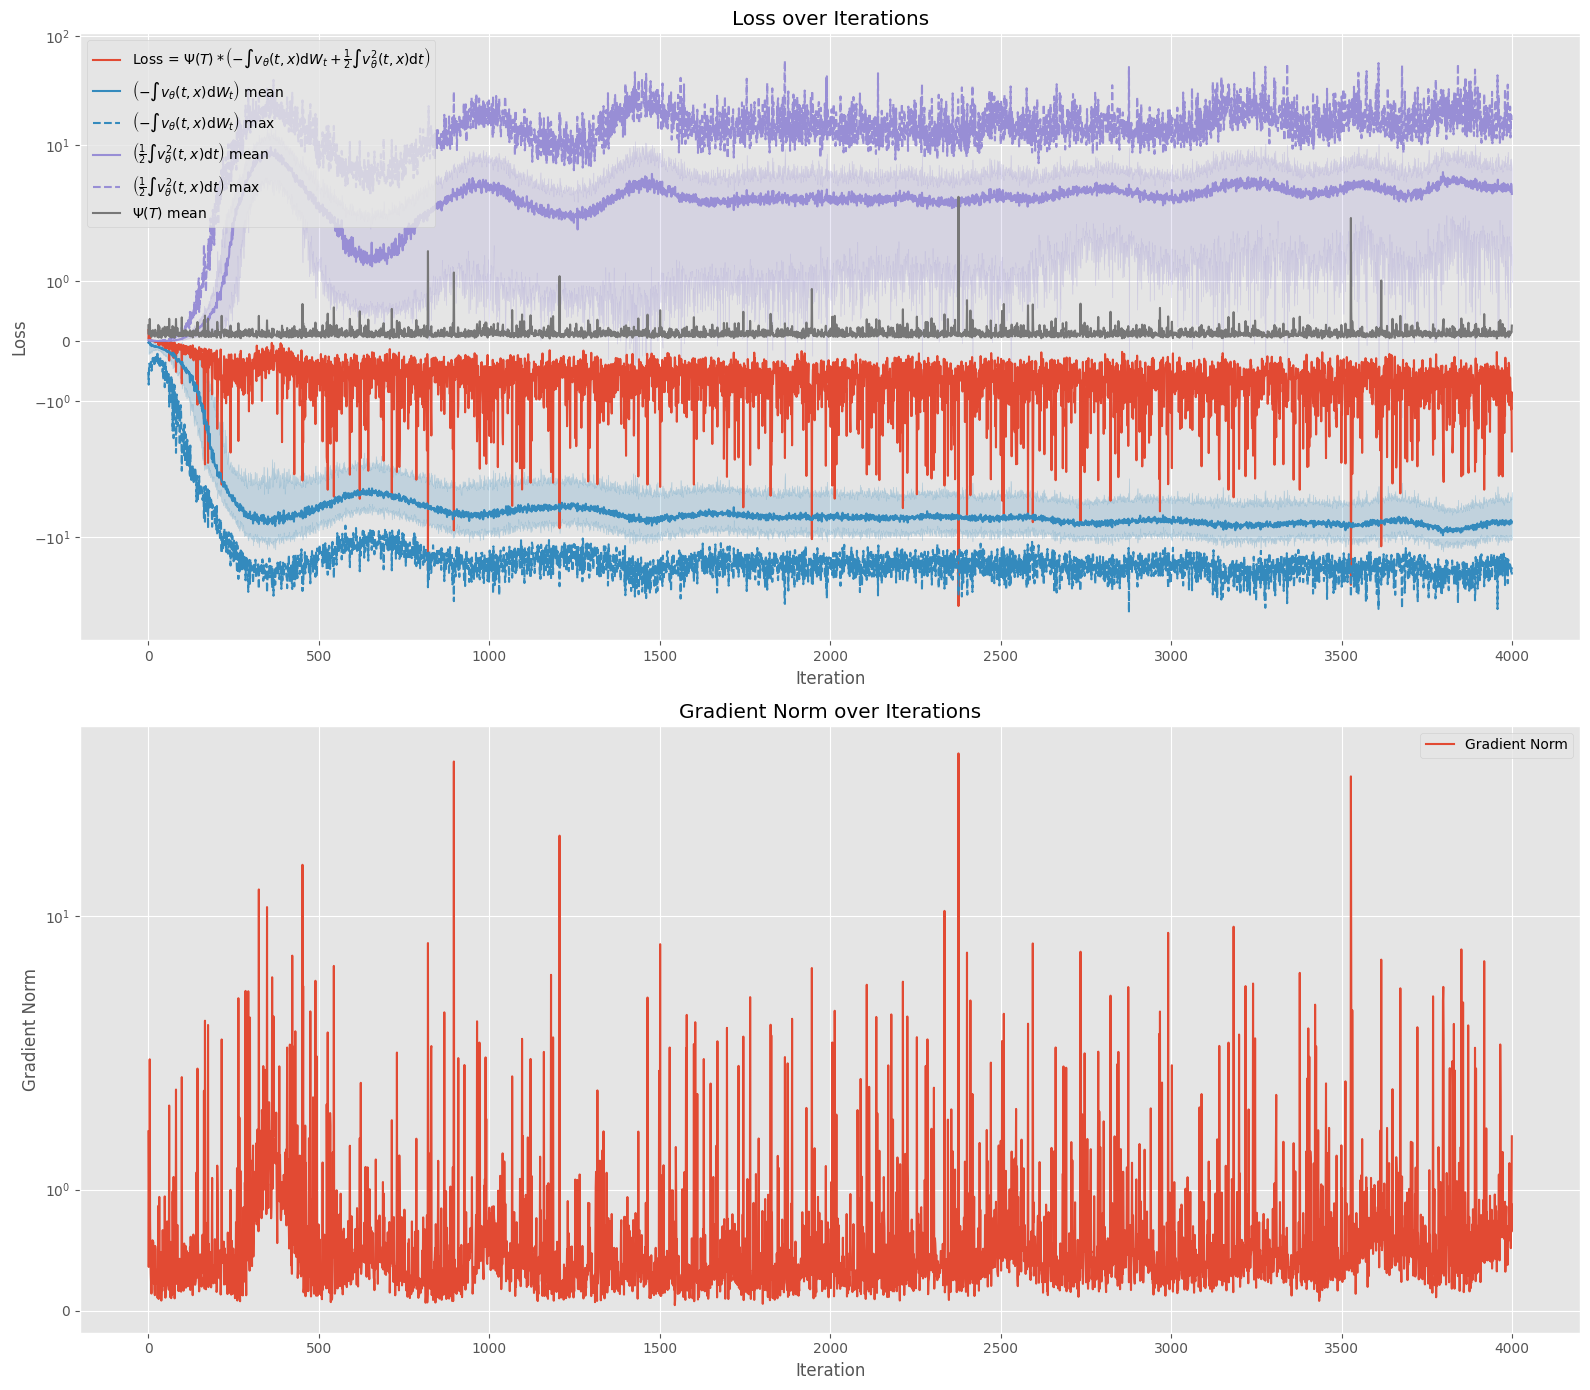

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))

# Plotting the losses
ax1.plot(losses, label=r'Loss = $\Psi(T) * \left(-\int v_{\theta}(t, x)\mathrm{d}W_t + \frac{1}{2}\int v_{\theta}^2(t, x)\mathrm{d}t\right)$')
mean = -sto_ints.mean(axis=1)
std = sto_ints.std(axis=1)
ax1.plot(mean, label=r'$\left(-\int v_{\theta}(t, x)\mathrm{d}W_t\right)$ mean')
ax1.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=ax1.lines[1].get_color())
ax1.plot(-sto_ints.max(axis=1), label=r'$\left(-\int v_{\theta}(t, x)\mathrm{d}W_t\right)$ max', linestyle='--', color=ax1.lines[1].get_color())
mean = det_ints.mean(axis=1)
std = det_ints.std(axis=1)
ax1.plot(mean, label=r'$\left(\frac{1}{2}\int v_{\theta}^2(t, x)\mathrm{d}t\right)$ mean')
ax1.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=ax1.lines[3].get_color())
ax1.plot(det_ints.max(axis=1), label=r'$\left(\frac{1}{2}\int v_{\theta}^2(t, x)\mathrm{d}t\right)$ max', linestyle='--', color=ax1.lines[3].get_color())
mean = lls.mean(axis=1)
std = lls.std(axis=1)
ax1.plot(mean, label=r'$\Psi(T)$ mean')
# ax1.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=ax1.lines[4].get_color())
# ax1.plot(lls.max(axis=1), label=r'$\Psi(T)$ max', linestyle='--', color=ax1.lines[5].get_color())
ax1.set_yscale('symlog')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Iterations')
ax1.legend()
ax1.grid(True)


# Plotting the gradient norms
ax2.plot(gradient_norms, label='Gradient Norm')
ax2.set_yscale('symlog')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Gradient Norm')
ax2.set_title('Gradient Norm over Iterations')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [79]:
def nu_learned(t, x):
    return model_state.apply_fn(
        {"params": model_state.params, "batch_stats": model_state.batch_stats}, 
        t, 
        x, 
        training=False,
        mutable=False
    )


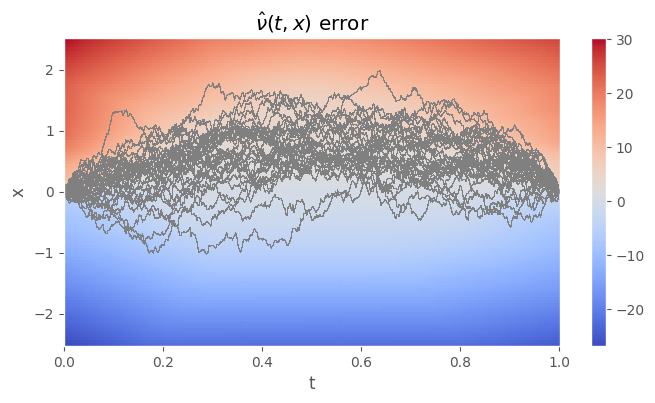

In [80]:
guided_bridge_paths = guided_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, batch_size=32)
ts = guided_bridge_paths.ts
xs = jnp.linspace(-2.5, 2.5, 100)
xs, ts = jnp.meshgrid(xs, ts)
xs_, ts_ = jnp.ravel(xs), jnp.ravel(ts)
learned_nus = jax.vmap(
    lambda t, x: nu_learned(t, x)
)(ts_, jnp.expand_dims(xs_, axis=-1)).reshape(xs.shape)

fig, ax = plt.subplots(figsize=(8, 4))
c1 = ax.pcolor(ts, xs, learned_nus - (-gamma / sigma), cmap='coolwarm')
for i in range(32):
    ax.plot(ts, guided_bridge_paths.xs[i], color='grey', linewidth=0.1)
fig.colorbar(c1, ax=ax)
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title(r"$\hat{\nu}(t, x)$ error")
plt.show()

In [81]:
# nu_learned = lambda t, x: - gamma / sigma * jnp.ones_like(x)

mixed_bridge_proc = MixedGuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    x0=x0,
    v=v,
    nu=nu_learned,
    ts=wiener_proc.ts,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10,
)

In [82]:
mixed_bridge_solver = Euler(sde=mixed_bridge_proc, wiener=wiener_proc)
mixed_bridge_paths = mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, batch_size=batch_size)


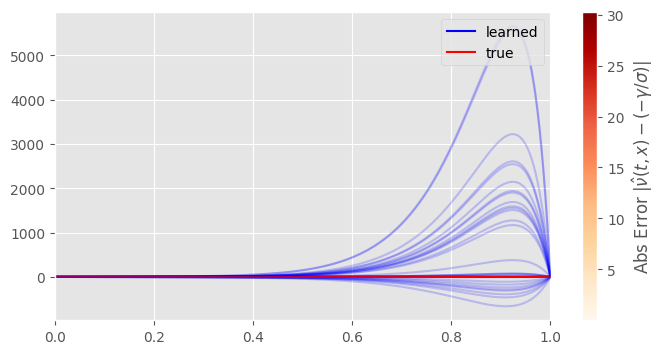

In [84]:
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(32):
    ax.plot(mixed_bridge_paths.ts, mixed_bridge_paths.xs[i], color='blue', alpha=0.2)
    ax.plot(true_bridge_paths.ts, true_bridge_paths.xs[i], color='red', alpha=0.2)
    
ax.plot([], [], color='blue', label='learned')
ax.plot([], [], color='red', label='true')
error = jnp.abs(learned_nus - (-gamma / sigma))
c2 = ax.pcolor(ts, xs, error, cmap='OrRd')
cbar = fig.colorbar(c2, ax=ax)
cbar.set_label(r"Abs Error $|\hat{\nu}(t, x) - (-\gamma / \sigma)|$")
# ax.set_ylim(-2.5, 2.5)
ax.legend(loc='upper right')
# fig.savefig("brownian_kld_loss.png", dpi=300)
